In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 0.1.dev19056+g5a5f803 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../../')
from Dataset_Creation import sys_dataset
import Dataset_load

In [3]:
dataset_standard  = Dataset_load.create_asimov()
dataset_asimov  = Dataset_load.create_asimov()

## Varying the Exposure

In [4]:
factor_neg = -0.1
factor_pos = +0.1

In [5]:
sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0, 
                        tilt = 0,
                        bias = 0, 
                        resolution = 0,
                        e_reco_creation = 10,
                        rnd = False)
dataset_cor = sys_d_cor.create_dataset()

sys_d_neg = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = factor_neg, 
                        tilt = 0,
                        bias = 0, 
                        resolution = 0,
                        e_reco_creation = 10,
                        rnd = False)
dataset_neg = sys_d_neg.create_dataset()

sys_d_pos = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = factor_pos, 
                        tilt = 0,
                        bias = 0, 
                        resolution = 0,
                        e_reco_creation = 10,
                        rnd = False)
dataset_pos = sys_d_pos.create_dataset()



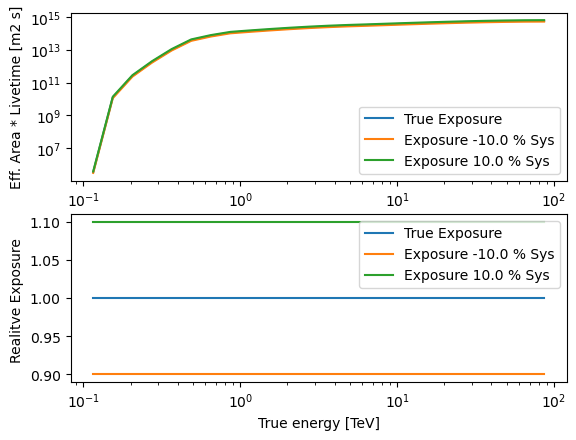

In [6]:
fig,ax = plt.subplots(2,1)

true_energy = dataset_cor.exposure.geom.axes[0].center.value
exposure_e = dataset_cor.exposure.data.sum(axis =2).sum(axis =1)

ax[0].plot(true_energy, exposure_e, label = "True Exposure")
ax[0].plot(true_energy, dataset_neg.exposure.data.sum(axis =2).sum(axis =1),
           label = "Exposure {:.3} % Sys".format(factor_neg *100))
ax[0].plot(true_energy, dataset_pos.exposure.data.sum(axis =2).sum(axis =1), 
           label = "Exposure {:.4} % Sys".format(factor_pos * 100))

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel("")
ax[0].set_ylabel(f"Eff. Area * Livetime [{dataset_standard.exposure.unit}]")
ax[0].legend()

ax[1].plot(true_energy, exposure_e/exposure_e, label = "True Exposure")
ax[1].plot(true_energy, (dataset_neg.exposure.data.sum(axis =2).sum(axis =1))/exposure_e,
           label = "Exposure {:.3} % Sys".format(factor_neg *100))
ax[1].plot(true_energy, (dataset_pos.exposure.data.sum(axis =2).sum(axis =1))/ exposure_e, 
           label = "Exposure {:.4} % Sys".format(factor_pos * 100))

#ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel("True energy [TeV]")
ax[1].set_ylabel(f"Realitve Exposure ")
ax[1].legend()

fig.savefig("plots/1_exposure_example.pdf")

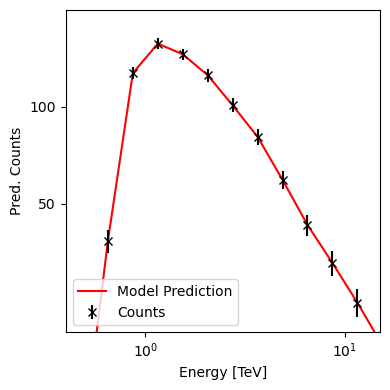

In [11]:

fig,ax = plt.subplots(1,1, sharey = True, figsize = (4,4))

ax = [ax]
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

npred =     dataset_cor.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_neg = dataset_neg.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_pos = dataset_pos.npred_signal().data.sum(axis = 2).sum(axis= 1)


ax[0].plot(true_energy, npred, label = "Model Prediction", color = 'red')
ax[0].errorbar(true_energy, npred, yerr= 0.5 * np.sqrt(npred),  fmt = 'x', label = "Counts",
              color = 'black')
ax[0].loglog()
ax[0].legend(loc = 'lower left')
ax[0].set_xlabel("Energy [TeV]")
ax[0].set_ylabel("Pred. Counts")
ax[0].set_ylim(2e1, 2e2)
ax[0].set_xlim(0.4, 15)
plt.minorticks_off()
ax[0].set_yticks([50,100], ['50', '100'])
plt.tight_layout()
fig.savefig("plots/1_counts_single_no_sys.svg")

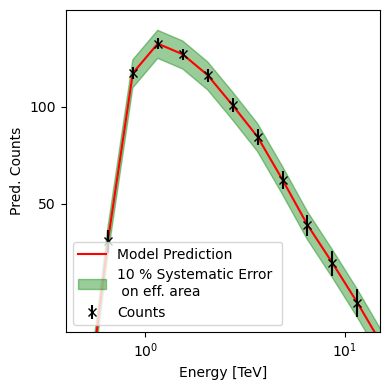

In [12]:

fig,ax = plt.subplots(1,1, sharey = True, figsize = (4,4))

ax = [ax]
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

npred =     dataset_cor.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_neg = dataset_neg.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_pos = dataset_pos.npred_signal().data.sum(axis = 2).sum(axis= 1)


ax[0].plot(true_energy, npred, label = "Model Prediction", color = 'red')
ax[0].errorbar(true_energy, npred, yerr= 0.5 * np.sqrt(npred),  fmt = 'x', label = "Counts",
              color = 'black')
ax[0].fill_between(true_energy, npred_neg, npred_pos,  label = "10 % Systematic Error \n on eff. area",
                  color = 'green', alpha = 0.4)
ax[0].loglog()
ax[0].legend(loc = 'lower left')
ax[0].set_xlabel("Energy [TeV]")
ax[0].set_ylabel("Pred. Counts")
ax[0].set_ylim(2e1, 2e2)
plt.minorticks_off()
ax[0].set_yticks([50,100], ['50', '100'])
ax[0].set_xlim(0.4, 15)
plt.tight_layout()

fig.savefig("plots/1_counts_single.svg")

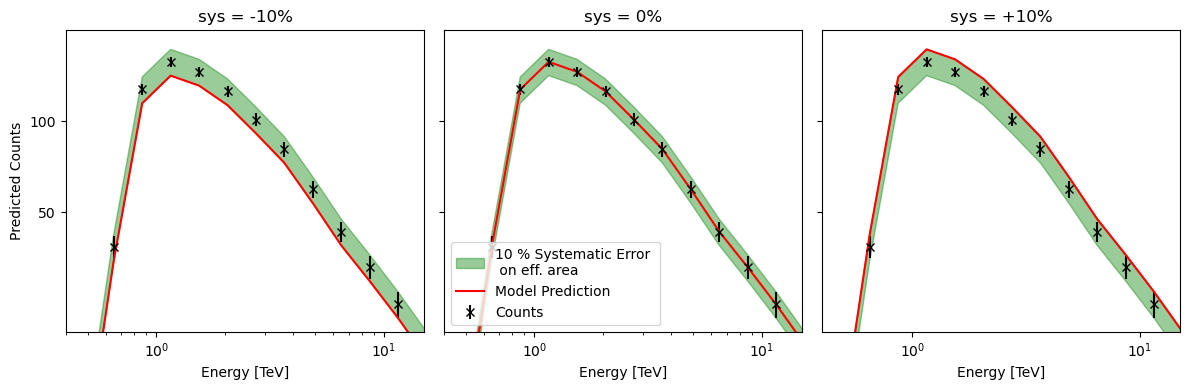

In [10]:

fig,ax = plt.subplots(1,3, sharey = True, figsize =  (12,4))

energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

for a in ax:
    a.errorbar(true_energy, npred, yerr= 0.5 * np.sqrt(npred),  fmt = 'x', label = "Counts",
                  color = 'black')
    a.fill_between(true_energy, npred_neg, npred_pos,  label = "10 % Systematic Error \n on eff. area",
                      color = 'green', alpha = 0.4)
    a.loglog()
ax[0].plot(true_energy, npred_neg, label = "Model Prediction", color = 'red')
ax[1].plot(true_energy, npred, label = "Model Prediction", color = 'red')
ax[2].plot(true_energy, npred_pos, label = "Model Prediction", color = 'red')

ax[1].legend(loc = 'lower left')
ax[0].set_ylabel("Predicted Counts")

for a in ax:
    a.set_ylim(2e1, 2e2)
    a.set_xlim(0.4, 15)
    a.set_xlabel("Energy [TeV]")

ax[0].set_title("sys = -10%"); ax[1].set_title("sys = 0%"); ax[2].set_title("sys = +10%"); 
plt.minorticks_off()
ax[0].set_yticks([50,100], ['50', '100'])
plt.tight_layout()
fig.savefig("plots/1_counts.pdf")

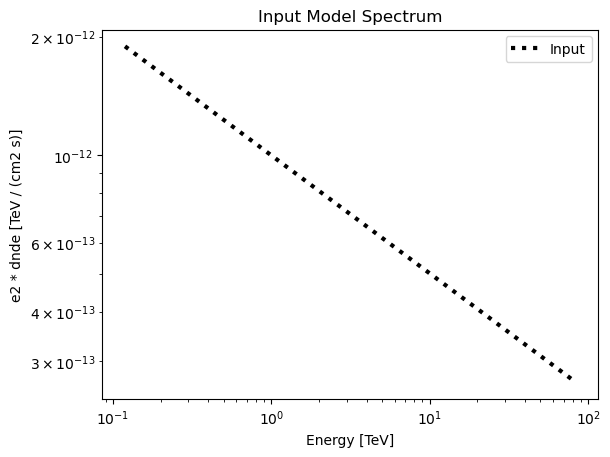

In [16]:
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
#dataset_cor.models['Source'].spectral_model.plot(energy_bounds, label = "Spectrum")
#dataset_neg.models['Source'].spectral_model.plot(energy_bounds, label = "")
#dataset_pos.models['Source'].spectral_model.plot(energy_bounds, label = "")
dataset_standard.models['Source'].spectral_model.plot(energy_bounds, energy_power = 2,
                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')
plt.title("Input Model Spectrum")
plt.legend()

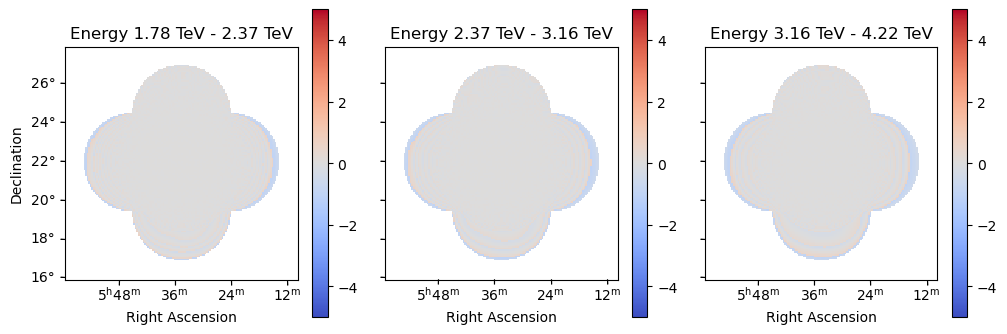

In [17]:
estimator = ExcessMapEstimator(
    correlation_radius=f"0.2 deg",
    energy_edges=dataset_cor.counts.geom.axes['energy'].edges[10:14])
result = estimator.run(dataset_cor)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

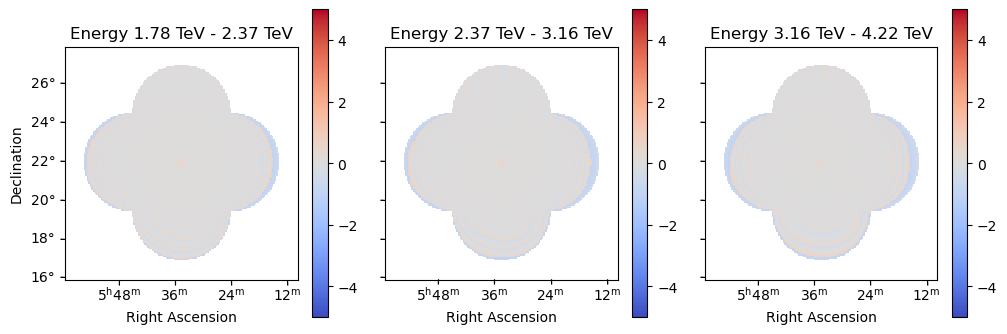

In [18]:
result = estimator.run(dataset_neg)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

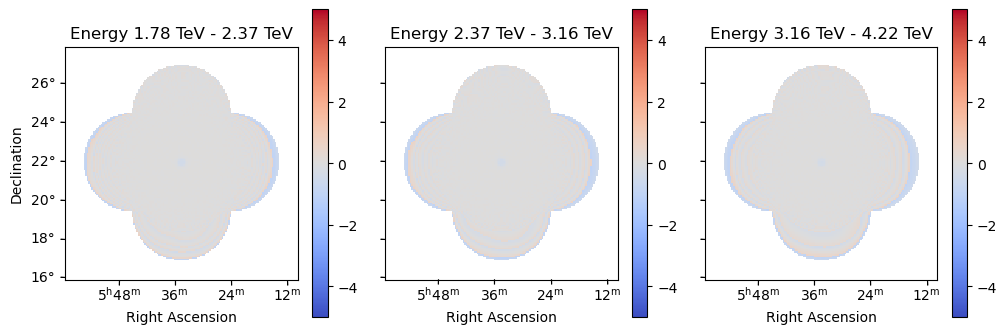

In [19]:
result = estimator.run(dataset_pos)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

In [20]:
%%time
fit_cor = Fit(store_trace=False)
result_cor = fit_cor.run([dataset_cor])
fit_neg = Fit(store_trace=False)
result_neg = fit_neg.run([dataset_neg])
fit_pos = Fit(store_trace=False)
result_pos = fit_pos.run([dataset_pos])

CPU times: user 7.47 s, sys: 39.8 ms, total: 7.51 s
Wall time: 7.51 s


In [21]:
datasets_short = [dataset_neg, dataset_cor, dataset_pos]
print("best fit amplitude")
amplitudes = []
m = dataset_standard.models['Source']
value = m.parameters['amplitude'].value 
error = m.parameters['amplitude'].error
amplitudes.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes.append((value, error))
    print(f'{value} pm {error}')
print()
print("best fit Index")
indices = []
m = dataset_standard.models['Source']
value = m.parameters['index'].value 
error = m.parameters['index'].error
indices.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices.append((value, error))
    print(f'{value} pm {error}')
print()

print("Best Fit bkg Norm")
norms = []
value = dataset_standard.background_model.parameters['norm'].value 
error = dataset_standard.background_model.parameters['norm'].error
norms.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.background_model.parameters['norm'].value 
    error = d.background_model.parameters['norm'].error
    print(f'{value} pm {error}')
    norms.append((value, error))
    
    
    
with open('data/1_norms.yaml', 'w') as file:
    documents = yaml.dump(norms, file)
with open('data/1_amplitudes.yaml', 'w') as file:
    documents = yaml.dump(amplitudes, file)
with open('data/1_indices.yaml', 'w') as file:
    documents = yaml.dump(indices, file)
    
dataset_neg.models.write("data/1_model_neg.yml", overwrite= True)
dataset_pos.models.write("data/1_model_pos.yml", overwrite= True)
dataset_cor.models.write("data/1_model_cor.yml", overwrite= True)

best fit amplitude
====
Input
1e-12 pm 0
====
1.1173833498895188e-12 pm 1.0031911400518072e-13
1.0030608592614636e-12 pm 9.015036643474451e-14
9.122716607749086e-13 pm 8.374302828497446e-14

best fit Index
====
Input
2.3 pm 0
====
2.303439126724729 pm 0.06188428154993858
2.3020586206139413 pm 0.061867216322487366
2.302382135605818 pm 0.06295929592881541

Best Fit bkg Norm
====
Input
1.0 pm 0
====
0.9999913441109249 pm 0.002065864638733681
1.0000033956165264 pm 0.0020659082146018705
0.9999632711594453 pm 0.0020279466110299975


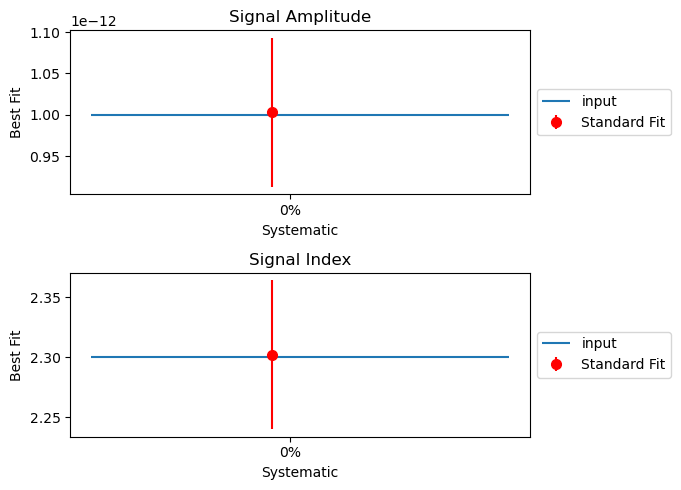

In [30]:
fig, axs = plt.subplots(2,1, figsize= (7, 5))

#axs[0].set_title("BKG Norm")
axs[0].set_title("Signal Amplitude")
axs[1].set_title("Signal Index")


labels_sys = [ '0%']
label = 'Standard Fit'
a = amplitudes[2]
i = 1
axs[0].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
               label = label)
a = indices[2]
axs[1].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
axs[0].hlines( amplitudes[0][0], 0.91, 3.2, label = "input")
axs[1].hlines( indices[0][0], 0.91, 3.2, label = "input")

plt.tight_layout()
for ax in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    ax.set_xlabel('Systematic'); 
    ax.set_xticks([2],labels_sys)

    
#axs[0].set_ylim(0.85, 1.15)
plt.tight_layout()    
#fig.savefig("plots/1_best_fit_parameters_0.pdf")   


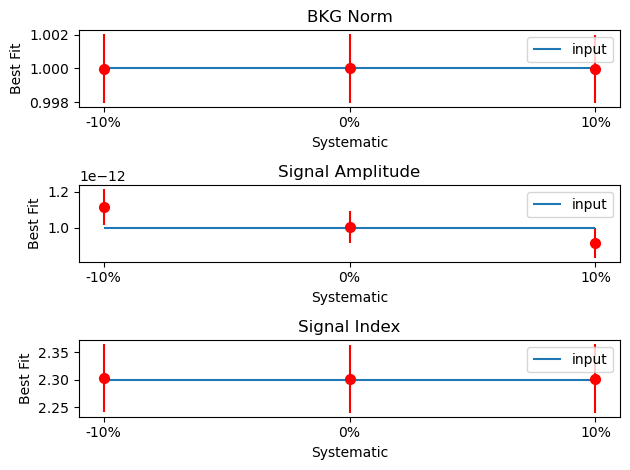

In [22]:
fig, axs = plt.subplots(3,1)

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")


labels = [ '-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
axs[0].hlines( norms[0][0], 1, 3, label = "input")

for i, a in enumerate(amplitudes[1:]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
axs[1].hlines( amplitudes[0][0], 1, 3, label = "input")

for i, a in enumerate(indices[1:]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
axs[2].hlines( indices[0][0], 1, 3, label = "input")

plt.tight_layout()
for a in axs:
    a.legend(); 
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels)

plt.tight_layout()    
fig.savefig("plots/1_best_fit_parameters_standard.pdf")   


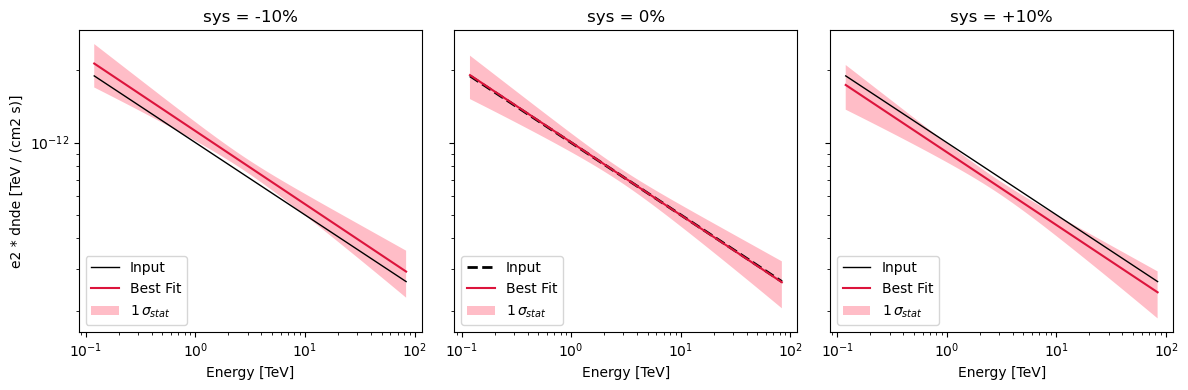

In [28]:
true_energy = dataset_cor.exposure.geom.axes[0].center.value
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV
fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )


dataset_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                label = "Best Fit", color = "crimson")
dataset_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "1$\,\sigma_{stat}$"
                                                         )
### cor 
dataset_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                label = "Best Fit", color = "crimson")
dataset_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "1$\,\sigma_{stat}$"
                                                         )
### pos 
dataset_pos.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                label = "Best Fit", color = "crimson")
dataset_pos.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "1$\,\sigma_{stat}$"
                                                         )
[a.legend(loc = 'lower left') for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/1_spectrum_standard.pdf")

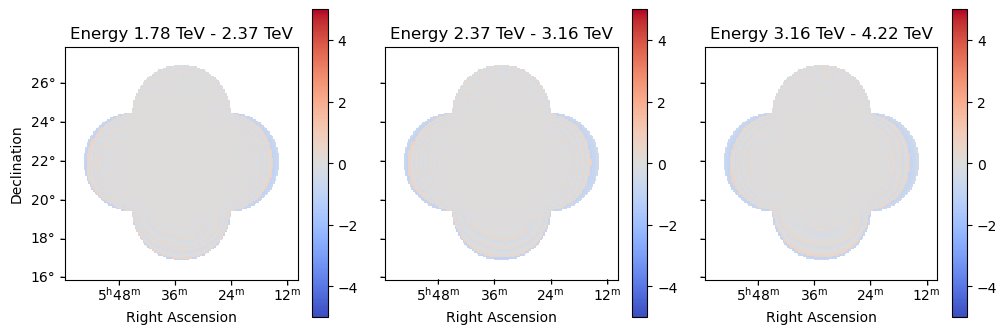

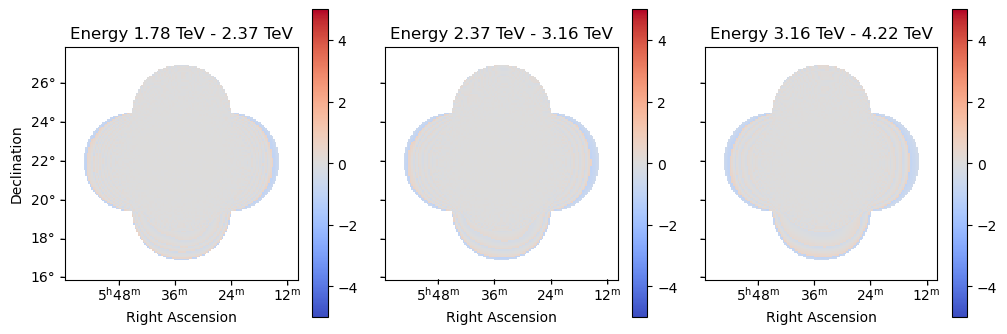

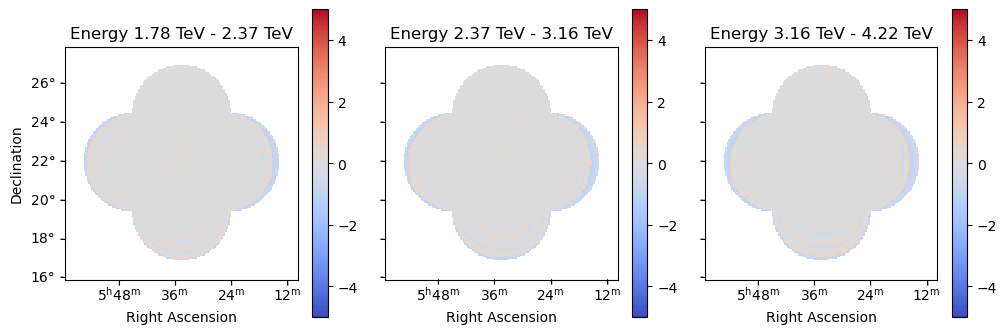

In [24]:

estimator = ExcessMapEstimator(
    correlation_radius=f"0.2 deg",
    energy_edges=dataset_cor.counts.geom.axes['energy'].edges[10:14])
result = estimator.run(dataset_cor)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);


result = estimator.run(dataset_neg)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);


result = estimator.run(dataset_pos)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);